In [1]:
import sys
import os

parent = os.path.dirname(os.path.abspath(''))
if not parent in sys.path:
    sys.path.append(parent)

import uproot

from anatree.ana_tools import manual_std
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d

import dunestyle.matplotlib as dunestyle

DUNE plot style enabled


In [2]:
def read_data(fname:str):
    with uproot.open(fname) as tree:
        data = tree.arrays(library='pd')

    data = pl.from_pandas(data)
    data = data.with_columns(
        nu_dcosx_truth = pl.col('TrueNuP_x')/pl.col('TrueNuE'),
        nu_dcosy_truth = pl.col('TrueNuP_y')/pl.col('TrueNuE'),
        nu_dcosz_truth = pl.col('TrueNuP_z')/pl.col('TrueNuE'),
    )
    return data

data = read_data('/pnfs/dune/persistent/users/pgranger/atmospherics-data/atmospherics_prod_1M_events_atmoana.root:analysistree/atmoOutput')


1.3684215963841506
1.910799341896809
1.4736569958931762


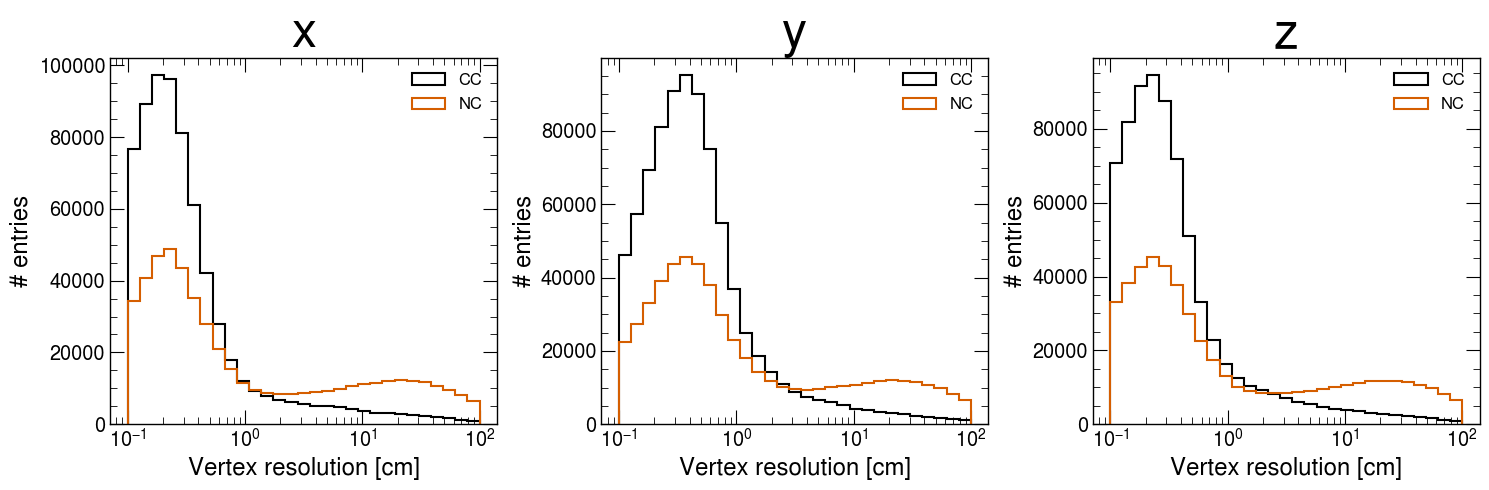

In [6]:
def vertex_plots(data):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    bins = np.logspace(-1, 2, 30)

    selected = data.filter(
        pl.col('RecoVtx_x') != -999
    )

    nc = selected.filter(
        pl.col('IsCC') == 0
    )

    cc = selected.filter(
        pl.col('IsCC') == 1
    )

    for i, direc in enumerate(['x', 'y', 'z']):
        ax = axs[i]
        ax.set_title(f'{direc}')
        ax.hist(np.abs(cc[f'TrueVtx_{direc}'] - cc[f'RecoVtx_{direc}']), bins=bins, histtype='step', label="CC")
        ax.hist(np.abs(nc[f'TrueVtx_{direc}'] - nc[f'RecoVtx_{direc}']), bins=bins, histtype='step', label="NC")
        print(np.average(np.abs(cc[f'TrueVtx_{direc}'] - cc[f'RecoVtx_{direc}'])))
        ax.set_xscale('log')
        ax.set_xlabel("Vertex resolution [cm]")
        ax.set_ylabel("# entries")
        ax.legend()
    fig.tight_layout()
    fig.savefig("vtx_res.pdf")
vertex_plots(data)

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 453874.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ -0.000532 │
│ std        ┆ 0.577937  │
│ min        ┆ -0.999993 │
│ 25%        ┆ -0.501957 │
│ 50%        ┆ -0.000884 │
│ 75%        ┆ 0.499318  │
│ max        ┆ 0.999993  │
└────────────┴───────────┘
[ 0.1         0.11253356  0.12663802  0.14251027  0.16037187  0.18047218
  0.20309176  0.22854639  0.25719138  0.28942661  0.32570207  0.36652412
  0.41246264  0.46415888  0.52233451  0.58780161  0.66147406  0.7443803
  0.83767764  0.94266846  1.06081836  1.19377664  1.34339933  1.51177507
  1.70125428  1.91448198  2.15443469  2.42446202  2.72833338  3.07029063
  3.45510729  3.88815518  4.37547938  4.92388263  5.54102033  6.23550734
  7.01703829  7.89652287  8.88623816 10.        ]
[        nan         nan 55.59541851 56.91098881 60.17359794 57.8136047
 53.11344607 51.48145 

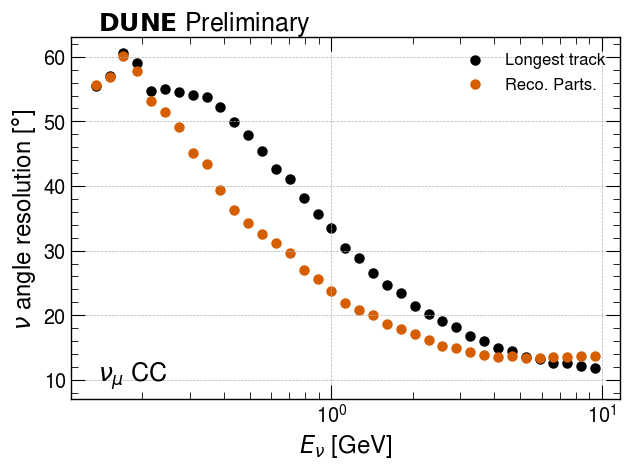

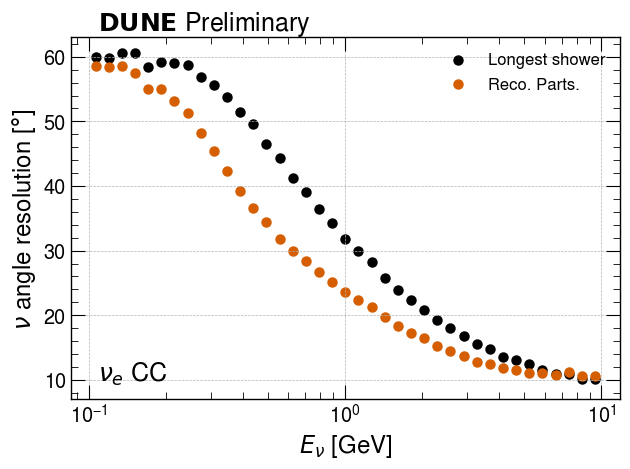

In [3]:
def direction_plots(data):
    numu_cc = data.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 14,
        pl.col("DirectionRecNuMu_y").abs() <= 1,
        pl.col("DirectionRecNuMuPfps_y").abs() <= 1,
        pl.col('nu_dcosy_truth').abs() <= 1
        ).drop_nulls()
    nue_cc = data.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 12,
        pl.col("DirectionRecNuE_y").abs() <= 1,
        pl.col("DirectionRecNuEPfps_y").abs() <= 1,
        pl.col('nu_dcosy_truth').abs() <= 1
        ).drop_nulls()
    Ebins = np.logspace(-1, 1, 40)
    # for direc in ['x', 'y', 'z']:
    for direc in ['y']:
        # fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

        fig1 = plt.figure()

        print(numu_cc[f'nu_dcos{direc}_truth'].describe())
        Ebins = np.logspace(-1, 1, 40)
        std, _, _ = binned_statistic(numu_cc['TrueNuE'], (np.arccos(numu_cc[f'nu_dcos{direc}_truth']) - np.arccos(numu_cc[f'DirectionRecNuMu_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Longest track", marker='o')
        
        std_new, _, _ = binned_statistic(numu_cc['TrueNuE'], (np.arccos(numu_cc[f'nu_dcos{direc}_truth']) - np.arccos(numu_cc[f'DirectionRecNuMuPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_new, label="Reco. Parts.", marker='o')
        print(Ebins)
        print(std_new)

        plt.xscale('log')
        plt.ylabel(r'$\nu$ angle resolution [$\degree$]')
        plt.xlabel(r'$E_\nu$ [GeV]')
        plt.ylim(7, 63)
        plt.legend()
        # axs[0].set_title(r'$\nu_\mu$ CC')
        plt.grid()
        dunestyle.Preliminary(y=1.02)
        dunestyle.TextLabel(text=r'$\nu_\mu$ CC', x=0.05, y=0.05)

        fig1.tight_layout()
        fig1.savefig('numu_angle_reco.pdf')

        fig2 = plt.figure()

        std, _, _ = binned_statistic(nue_cc['TrueNuE'], (np.arccos(nue_cc[f'nu_dcos{direc}_truth']) - np.arccos(nue_cc[f'DirectionRecNuE_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Longest shower", marker='o')
        

        std_new, _, _ = binned_statistic(nue_cc['TrueNuE'], (np.arccos(nue_cc[f'nu_dcos{direc}_truth']) - np.arccos(nue_cc[f'DirectionRecNuEPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_new, label="Reco. Parts.", marker='o')
        print(std_new)

        plt.xscale('log')
        # axs[1].set_ylabel('Neutrino angle resolution [deg]')
        plt.xlabel(r'$E_\nu$ [GeV]')
        plt.ylabel(r'$\nu$ angle resolution [$\degree$]')
        plt.ylim(7, 63)
        plt.legend()
        # axs[1].set_title(r'$\nu_e$ CC')
        plt.grid()

        dunestyle.Preliminary(y=1.02)
        dunestyle.TextLabel(text=r'$\nu_e$ CC', x=0.05, y=0.05)

        fig2.tight_layout()
        fig2.savefig("nue_angle_reco.pdf")
direction_plots(data)

NC 0.17822515964508057
NuE 0.5659912824630737
NuMu 0.5351243615150452


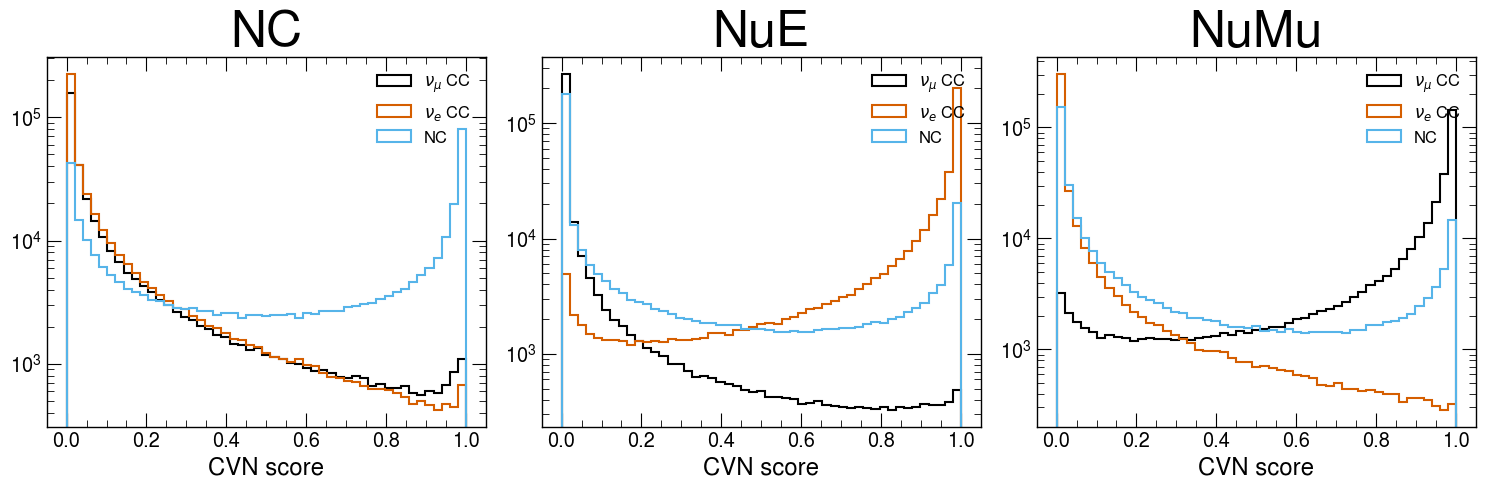

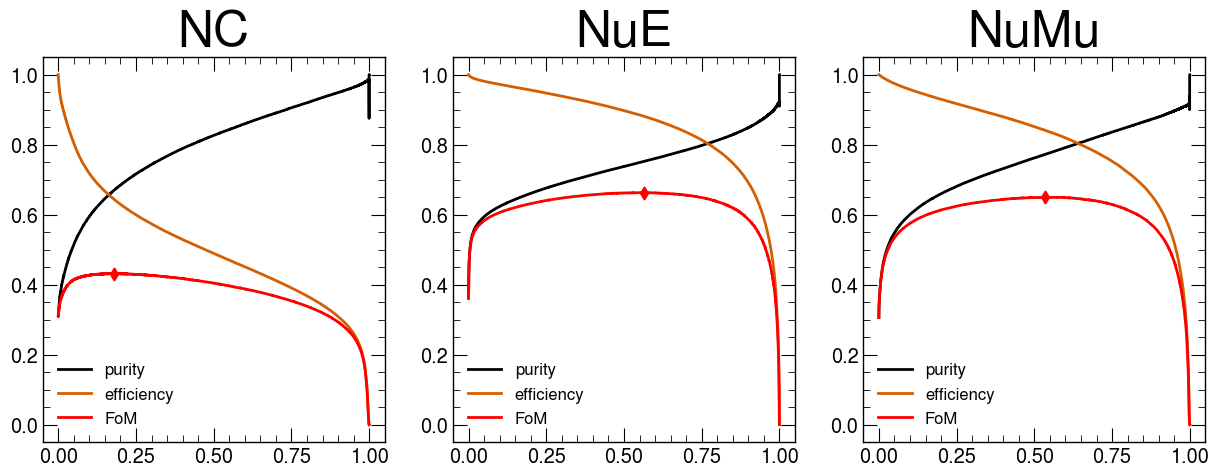

In [5]:
def fom(category, scores):
    sorted_indices = np.argsort(scores)[::-1]  # Sort scores in descending order
    sorted_scores = scores[sorted_indices]
    sorted_category = category[sorted_indices]
    true_positives_cumsum = np.cumsum(sorted_category)
    total_positives = np.sum(sorted_category)
    total_events = len(sorted_scores)

    efficiency = true_positives_cumsum / total_positives

    purity = true_positives_cumsum / np.arange(1, total_events + 1)
    return sorted_scores, purity, efficiency

def cvn_plots(data):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    bins = np.linspace(0, 1, 50)
    numu_cc = data.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 14
        ).drop_nulls().filter(
    pl.col('TrueNuE') < 4
)
    nue_cc = data.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 12
        ).drop_nulls().filter(
    pl.col('TrueNuE') < 4
)
    nc = data.filter(
        pl.col('IsCC') == 0
    ).drop_nulls().filter(
    pl.col('TrueNuE') < 4
)

    selected = data.filter(
        pl.col('CVNScoreNC').abs() <= 1,
        pl.col('CVNScoreNuE').abs() <= 1,
        pl.col('CVNScoreNuMu').abs() <= 1,
    ).drop_nulls()

    

    fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))

    selections = [
        pl.col('IsCC') == 0,
        (pl.col('IsCC') == 1) & (pl.col("TrueNuPdg").abs() == 12),
        (pl.col('IsCC') == 1) & (pl.col("TrueNuPdg").abs() == 14)
        ]

    for i, flav in enumerate(['NC', 'NuE', 'NuMu']):
        ax = axs[i]
        score = f'CVNScore{flav}'
        ax.hist(numu_cc[score], bins=bins, label=r'$\nu_\mu$ CC', histtype='step')
        ax.hist(nue_cc[score], bins=bins, label=r'$\nu_e$ CC', histtype='step')
        ax.hist(nc[score], bins=bins, label='NC', histtype='step')
        ax.set_yscale('log')
        ax.set_xlabel("CVN score")
        ax.legend()
        ax.set_title(flav)

        category = selected.with_columns(
            category = selections[i]
        )['category'].to_numpy()

        sorted_scores, purity, efficiency = fom(category, selected[score].to_numpy())
        axs2[i].plot(sorted_scores, purity, label='purity')
        axs2[i].plot(sorted_scores, efficiency, label='efficiency')
        axs2[i].plot(sorted_scores, efficiency*purity, color='red', label='FoM')
        axs2[i].legend()
        axs2[i].set_title(flav)

        cut_idx = np.argmax(efficiency*purity)
        cut_value = sorted_scores[cut_idx]
        axs2[i].scatter(cut_value, efficiency[cut_idx]*purity[cut_idx], color='red', marker='d')
        print(flav, cut_value)
    fig.tight_layout()
    fig.savefig("cvn_flavour.pdf")
cvn_plots(data)

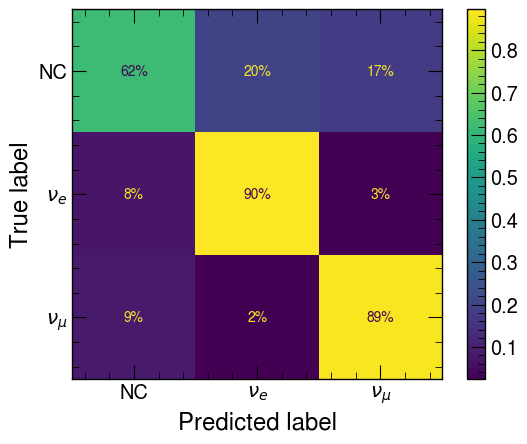

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

kNuE = 0
kNuMu = 1
kNC = 2
kUndef = 3

selected = data.filter(
    pl.col('CVNScoreNC').abs() <= 1,
    pl.col('CVNScoreNuE').abs() <= 1,
    pl.col('CVNScoreNuMu').abs() <= 1,
).drop_nulls().with_columns(
    category = pl.when(
        pl.col('CVNScoreNuE').abs() > 0.57
    ).then(
        kNuE
    ).otherwise(
        pl.when(
            pl.col('CVNScoreNuMu').abs() > 0.54
            ).then(
                kNuMu
            ).otherwise(
                pl.when(
                    pl.col('CVNScoreNC').abs() > 0.18
                ).then(
                    kNC
                ).otherwise(
                    kUndef
                )

            )       
    ),
    category_true = pl.when(
        pl.col('IsCC') == 0
    ).then(
        kNC
    ).otherwise(
        pl.when(
            pl.col("TrueNuPdg").abs() == 12
        ).then(
            kNuE
        ).otherwise(
            kNuMu
        )
    )
).filter(
    pl.col('TrueNuE') < 4
)

mat = ConfusionMatrixDisplay.from_predictions(selected["category_true"], selected["category"], labels=[kNC, kNuE, kNuMu], display_labels=["NC",r"$\nu_e$", r"$\nu_\mu$"], normalize='true', values_format=".0%")
# plt.savefig("confusion_matrix.pdf")
mat.figure_.savefig("confusion_matrix.png", dpi=300)

/tmp/ipykernel_294384/4121641907.py:64: RuntimeWarning: invalid value encountered in divide
  efficiency = nb_well_reco/nb_with_flavor


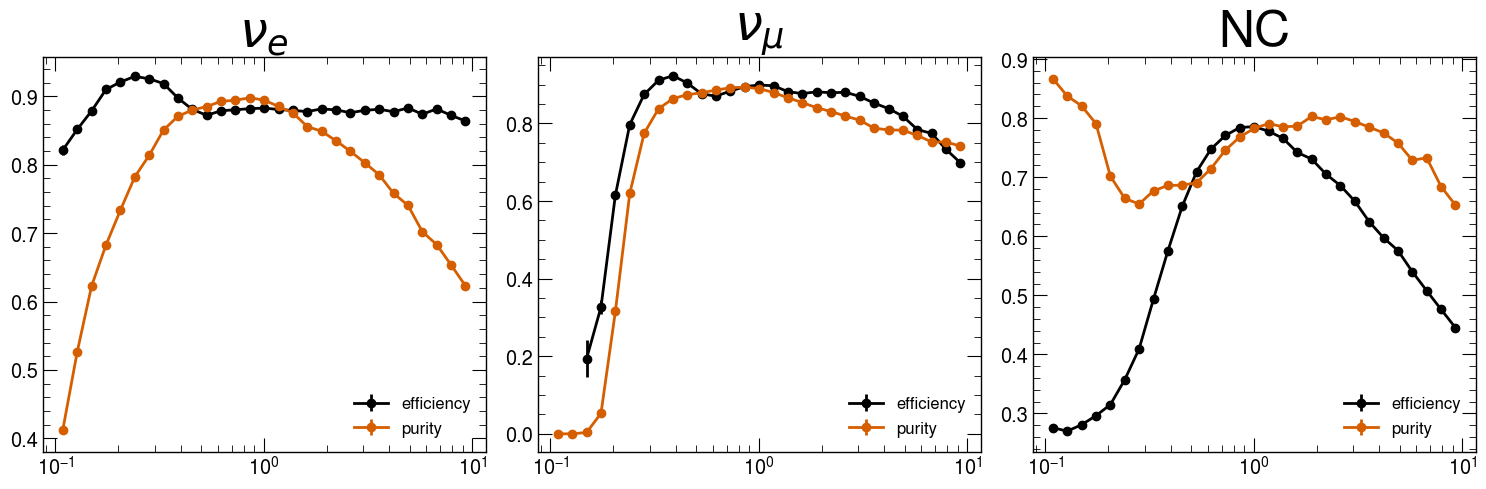

In [22]:
Ebins = np.logspace(-1, 1, 30)
selected = data.filter(
    pl.col('CVNScoreNC').abs() <= 1,
    pl.col('CVNScoreNuE').abs() <= 1,
    pl.col('CVNScoreNuMu').abs() <= 1,
).drop_nulls().with_columns(
    category = pl.when(
        pl.col('CVNScoreNuE').abs() > 0.57
    ).then(
        kNuE
    ).otherwise(
        pl.when(
            pl.col('CVNScoreNuMu').abs() > 0.54
            ).then(
                kNuMu
            ).otherwise(
                kNC
                # pl.when(
                #     pl.col('CVNScoreNC').abs() > 0.18
                # ).then(
                #     kNC
                # ).otherwise(
                #     kUndef
                # )

            )       
    ),
    category_true = pl.when(
        pl.col('IsCC') == 0
    ).then(
        kNC
    ).otherwise(
        pl.when(
            pl.col("TrueNuPdg").abs() == 12
        ).then(
            kNuE
        ).otherwise(
            kNuMu
        )
    )
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (flav, name) in enumerate(zip([kNuE, kNuMu, kNC], [r'$\nu_e$', r'$\nu_\mu$', 'NC'])):
    ax = axs[i]

    filtered = selected.filter(
        pl.col("category_true").abs() == flav
    )
    nb_with_flavor, _, _ = binned_statistic(filtered["TrueNuE"], None, 'count', bins=Ebins)

    filtered = selected.filter(
        pl.col("category").abs() == flav
    )
    nb_with_reco_flavor, _, _ = binned_statistic(filtered["TrueNuE"], None, 'count', bins=Ebins)

    filtered = selected.filter(
        pl.col("category").abs() == flav,
        pl.col("category_true").abs() == flav
    )
    nb_well_reco, _, _ = binned_statistic(filtered["TrueNuE"], None, 'count', bins=Ebins)

    efficiency = nb_well_reco/nb_with_flavor
    purity = nb_well_reco/nb_with_reco_flavor

    efficiency_err = np.sqrt(efficiency*(1-efficiency)/nb_with_flavor)
    purity_err = np.sqrt(purity*(1-purity)/nb_with_reco_flavor)

    ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), efficiency, yerr=efficiency_err, marker='o', label='efficiency')
    ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), purity, yerr=purity_err, marker='o', label='purity')
    ax.set_xscale('log')
    ax.legend()
    ax.set_title(name)
fig.tight_layout()

[-3.93722646e-115  5.54389927e+000]


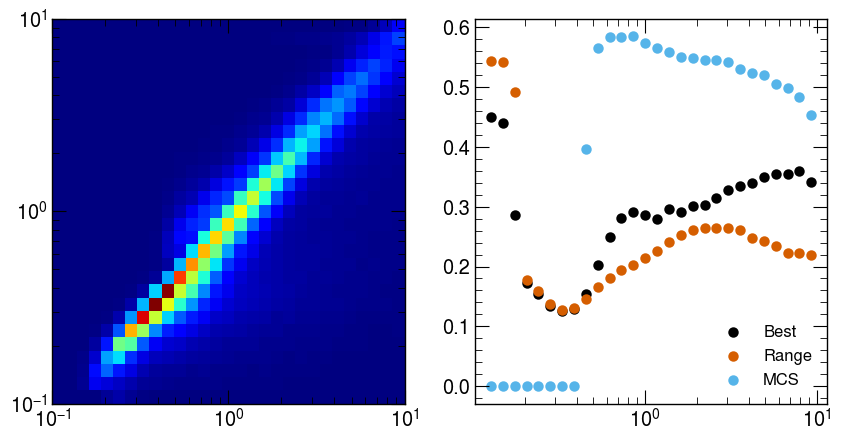

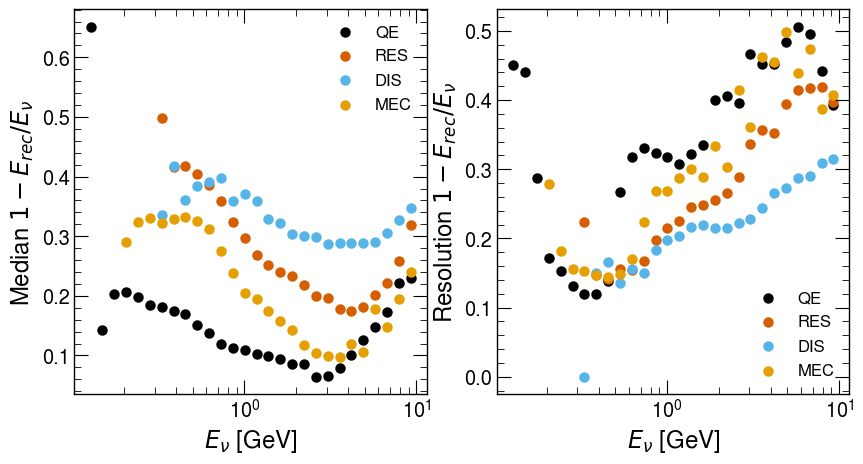

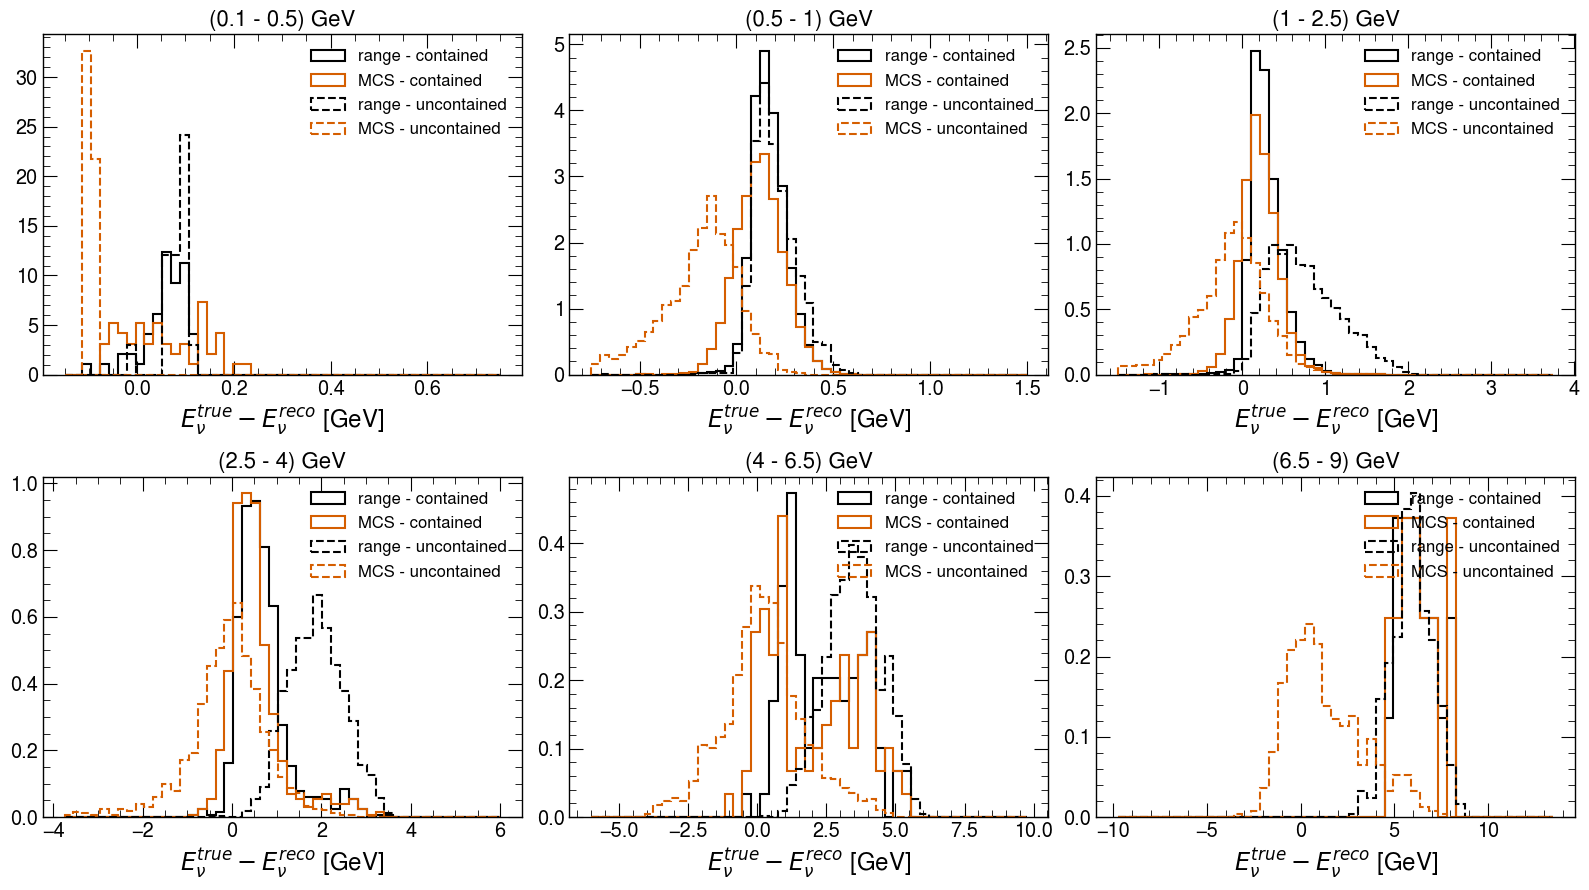

In [30]:
import dunestyle.matplotlib as dunestyle

def energy_plots(data):
    numu_cc = data.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 14,
        pl.col('ErecNuMu') < 1000
        ).drop_nulls()
    nue_cc = data.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 12,
        pl.col("DirectionRecNuE_y") > -999,
        pl.col('ErecNuE') < 1000
        ).drop_nulls()
    Ebins = np.logspace(-1, 1, 30)
    params = np.polyfit(numu_cc['ErecNuMu'].to_numpy(), numu_cc['TrueNuE'].to_numpy(), 1)
    print(params)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].hist2d(numu_cc['TrueNuE'], numu_cc['ErecNuMu'], bins=(Ebins, Ebins), cmap='jet')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # axs[1].hist(1 - numu_cc['ErecNuMu']/numu_cc['TrueNuE'], bins=np.linspace(-2, 2))
    #Nu_mu
    std, _, _ = binned_statistic(numu_cc['TrueNuE'], 1 - numu_cc['ErecNuMu']/numu_cc['TrueNuE'], statistic=manual_std, bins=Ebins)
    axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Best", marker='o')

    std, _, _ = binned_statistic(numu_cc['TrueNuE'], 1 - numu_cc['ErecNuMuRange']/numu_cc['TrueNuE'], statistic=manual_std, bins=Ebins)
    axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Range", marker='o')

    std, _, _ = binned_statistic(numu_cc['TrueNuE'], 1 - numu_cc['ErecNuMuMCS']/numu_cc['TrueNuE'], statistic=manual_std, bins=Ebins)
    axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="MCS", marker='o')
    axs[1].set_xscale('log')
    axs[1].legend()
    # std_new, _, _ = binned_statistic(numu_cc['TrueNuE'], (np.arccos(numu_cc[f'nu_dcos{direc}_truth']) - np.arccos(numu_cc[f'DirectionRecNuMuPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
    # axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_new, label="Reco. Parts.", marker='o')

    # axs[0].set_xscale('log')

    #Nu_e
    # std, _, _ = binned_statistic(nue_cc['TrueNuE'], (np.arccos(nue_cc[f'nu_dcos{direc}_truth']) - np.arccos(nue_cc[f'DirectionRecNuE_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
    # axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Longest track", marker='o')
    # std_new, _, _ = binned_statistic(nue_cc['TrueNuE'], (np.arccos(nue_cc[f'nu_dcos{direc}_truth']) - np.arccos(nue_cc[f'DirectionRecNuEPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
    # axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_new, label="Reco. Parts.", marker='o')
    # axs[1].set_xscale('log')

    # fig, ax = plt.subplots(1, 1)
    # distributions, edgesX, edgesY = np.histogram2d(numu_cc['TrueNuE'], 1 - numu_cc['ErecNuMu']/numu_cc['TrueNuE'], bins=(Ebins, np.linspace(-1, 1, 100)))
    # ax.plot(distributions.T)

    modes = {
        0: "QE",
        1: "RES",
        2: "DIS",
        10: "MEC"
    }

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for mode in modes.keys():
        filtered = numu_cc.filter(
            pl.col('InterMode') == mode
        )
        avg, _, _ = binned_statistic(filtered['TrueNuE'], 1 - filtered['ErecNuMu']/filtered['TrueNuE'], statistic='median', bins=Ebins)
        axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), avg, label=modes[mode])
        std, _, _ = binned_statistic(filtered['TrueNuE'], 1 - filtered['ErecNuMu']/filtered['TrueNuE'], statistic=manual_std, bins=Ebins)
        axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label=modes[mode])
    axs[0].set_xscale('log')
    axs[0].legend()
    axs[0].set_xlabel(r"$E_\nu$ [GeV]")
    axs[0].set_ylabel(r'Median $1 - E_{rec}/E_\nu$')
    axs[1].set_xscale('log')
    axs[1].legend()
    axs[1].set_xlabel(r"$E_\nu$ [GeV]")
    axs[1].set_ylabel(r'Resolution $1 - E_{rec}/E_\nu$')

    fig, axs = plt.subplots(2, 3, figsize=(16, 9))
    ranges = [
        (0.1, 0.5),
        (0.5, 1),
        (1, 2.5),
        (2.5, 4),
        (4, 6.5),
        (6.5, 9)
    ]
    for i, (El, Eh) in enumerate(ranges):
        ax = axs[i//3, i%3]
        events = filtered.filter(
            pl.col('TrueNuE') > El,
            pl.col('TrueNuE') < Eh,
            pl.col('ErecNuMuRange') > 0,
            pl.col('ErecNuMuMCS') > 0
        )
        cont = events.filter(pl.col('ErecNuMuRange') == pl.col('ErecNuMu'))
        uncont = events.filter(pl.col('ErecNuMuMCS') == pl.col('ErecNuMu'))
        # ax.hist(events['TrueNuE'] - events['ErecNuMu'], bins=np.linspace(-1.5*El, 1.5*Eh, 50), histtype='step', density=True, label="best")
        ax.hist(cont['TrueNuE'] - cont['ErecNuMuRange'], bins=np.linspace(-1.5*El, 1.5*Eh, 50), histtype='step', density=True, label="range - contained")
        ax.hist(cont['TrueNuE'] - cont['ErecNuMuMCS'], bins=np.linspace(-1.5*El, 1.5*Eh, 50), histtype='step', density=True, label="MCS - contained")
        ax.hist(uncont['TrueNuE'] - uncont['ErecNuMuRange'], bins=np.linspace(-1.5*El, 1.5*Eh, 50), histtype='step', density=True, label="range - uncontained", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linestyle='dashed')
        ax.hist(uncont['TrueNuE'] - uncont['ErecNuMuMCS'], bins=np.linspace(-1.5*El, 1.5*Eh, 50), histtype='step', density=True, label="MCS - uncontained", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], linestyle='dashed')
        ax.set_title(f"({El} - {Eh}) GeV", fontsize=16)
        ax.legend()
        ax.set_xlabel(r"$E_{\nu}^{true} - E_{\nu}^{reco}$ [GeV]")
    # plt.xscale('log')
    fig.tight_layout()
    fig.savefig("uncontained_diff.png", dpi=300)
energy_plots(data)